<a href="https://colab.research.google.com/github/JamesUMD/Kaggle/blob/main/Vehicle_Liscense_Plate/Vehicle_Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.optimizers import RMSprop

In [5]:
url = 'https://raw.githubusercontent.com/JamesUMD/Kaggle/main/Vehicle_Liscense_Plate/Indian_Number_plates.json'

df = pd.read_json(url, orient='columns', dtype='dict', lines = True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",None
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",None
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",None
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",None
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",None


In [6]:
import pathlib
file = pathlib.Path("Indian Number Plates")
if file.exists ():
  print("Yes")
else:
  os.makedirs("Indian Number Plates")

In [7]:
for dirname, _, filenames in os.walk('Indian Number Plates'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("licensed_car{}".format(counter))
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [9]:
df = pd.DataFrame(dataset)
df.head()
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [10]:
test_samples = np.random.randint(0, len(df), 10)
reduced_df = df.drop(test_samples, axis=0)

In [11]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

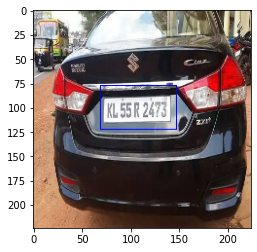

In [12]:
show_img(10)

In [13]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 205 validated image filenames.
Found 22 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

In [14]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 21,178,884
Trainable params: 6,464,196
Non-

In [15]:
adam = Adam(lr=0.0005)
model.compile(optimizer = adam , loss="mse", metrics='accuracy')

In [16]:
train_size = int(np.ceil(train_generator.n / train_generator.batch_size))
val_size = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", train_size )
print("Validation step size:", val_size)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


In [17]:
history = model.fit(train_generator, steps_per_epoch=train_size, validation_data=validation_generator, validation_steps=val_size,epochs=30)

Epoch 1/30
7/7 [==============================] - 66s 10s/step - loss: 0.0589 - accuracy: 0.4242 - val_loss: 0.0630 - val_accuracy: 0.5000
Epoch 2/30
7/7 [==============================] - 64s 9s/step - loss: 0.0427 - accuracy: 0.5051 - val_loss: 0.0339 - val_accuracy: 0.5000
Epoch 3/30
7/7 [==============================] - 64s 9s/step - loss: 0.0212 - accuracy: 0.6241 - val_loss: 0.0191 - val_accuracy: 0.5909
Epoch 4/30
7/7 [==============================] - 64s 9s/step - loss: 0.0095 - accuracy: 0.8145 - val_loss: 0.0185 - val_accuracy: 0.6364
Epoch 5/30
7/7 [==============================] - 64s 9s/step - loss: 0.0059 - accuracy: 0.8370 - val_loss: 0.0176 - val_accuracy: 0.7273
Epoch 6/30
7/7 [==============================] - 64s 9s/step - loss: 0.0035 - accuracy: 0.8952 - val_loss: 0.0155 - val_accuracy: 0.6818
Epoch 7/30
7/7 [==============================] - 64s 9s/step - loss: 0.0026 - accuracy: 0.8784 - val_loss: 0.0145 - val_accuracy: 0.7273
Epoch 8/30
7/7 [=================

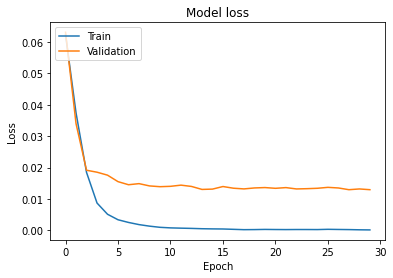

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
model.evaluate_generator(validation_generator, steps=val_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.01294647715985775, 0.7727272510528564]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


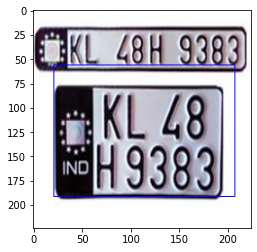

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


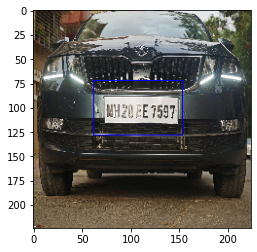

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


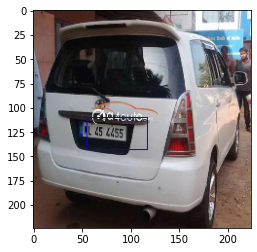

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


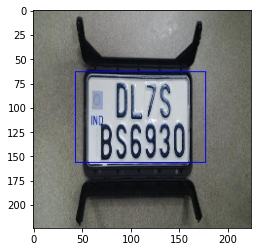

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


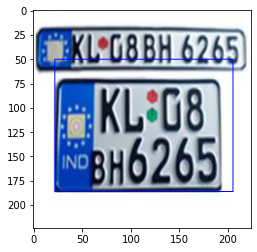

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


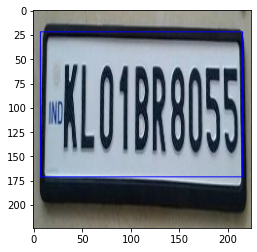

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


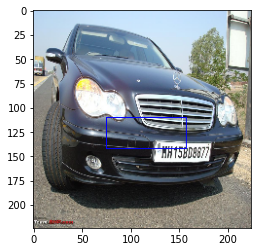

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


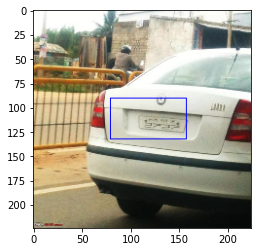

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


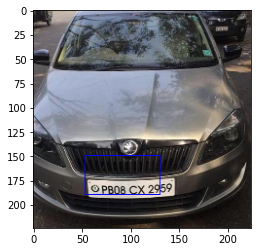

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


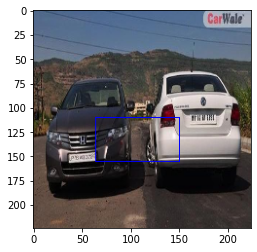

In [20]:
for idx, row in df.iloc[test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Indian Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()